In [90]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from astropy.table import Table
from astropy.io import ascii
import os
from astropy.table import QTable
from scipy.stats import spearmanr
from scipy import stats
from numpy import percentile

#remove scientific notation from output lists (prints 0.112 rather than 0.112000000e+00 for a float array element)
np.set_printoptions(suppress=True)

In [2]:
homedir = os.getenv("HOME")

#sga matched to VF catalog
sgacut = Table.read(homedir+'/sga_cut.fits',format='ascii')

#sga r50 parameters
sga_params = Table.read(homedir+'/sga_params')

#names (for check purposes)
vfid = sgacut['VFID']

In [3]:
#resizing sga_params table to only contain sgacut entries,
flag_p = []

for i in sga_params['name']:
    if i not in sgacut['VFID']:
        flag_p.append(False)
    else:
        flag_p.append(True)

sga_params = sga_params[flag_p]

#output is only 933, as compared with 1020 found previously with SGA-parent-v3.0.fits

In [4]:
#resizing sgacut to be compatible with sga_params...that is, both will have size 933

flag_p = []

for i in sgacut['VFID']:
    if i not in sga_params['name']:
        flag_p.append(False)
    else:
        flag_p.append(True)

sgacut = sgacut[flag_p]
vfid = vfid[flag_p]

In [5]:
#Note: VFIDs are not in order for sga_params, so we will use np.where to determine correct indices

# -------------------------------------------------------------------------------------------

In [6]:
#isolate late-type galaxies from sample using t-test
#the t-type is available in Hyperleda catalog, so will pull and cut this first 
#I worry doing so will restrict the sample even further, as there may be galaxies with an empty 
#classification cell. But I proceed.

hyp = Table.read(homedir+'/Desktop/v1-20210308/vf_north_v1_hyperleda.fits')

#for AGN cuts (see seven cells below), pull WISE catalog
wise = Table.read(homedir+'/Desktop/v1-20210308/vf_north_v1_unwise.fits')

#for BPT AGN cuts, pull nsa_v0 catalog
bpt = Table.read(homedir+'/Desktop/v1-20210308/vf_north_v1_nsa_v0.fits')

In [7]:
#I will add the name column to the wise table for ease of comparison -- otherwise, no comparison can occur.
wise.add_column(hyp['VFID'],name='VFID')

In [8]:
#resizing hyp to be compatible with subsample cut...that is, both will have size 933

flag_hyp = []

for i in hyp['VFID']:
    if i not in sga_params['name']:
        flag_hyp.append(False)
    else:
        flag_hyp.append(True)

hyp = hyp[flag_hyp]
wise = wise[flag_hyp]
bpt = bpt[flag_hyp]

In [9]:
#numerical Hubble stage/morphological types as defined on Hyperleda website:

V_class = []
for i in hyp['type_1']:
    if i not in V_class:
        V_class.append(i)

In [10]:
V_class = np.asarray(V_class).flatten()
V_class

array(['SABb', 'Sb', 'SABa', 'Sc', 'E', 'Sbc', 'Sab', 'SBbc', 'Sa', 'SBa',
       'SBcd', 'S?', 'SBb', 'S0-a', 'S0', 'N/A', 'SABc', 'Scd', 'E?',
       'SBc', 'E-S0', 'SBab', 'I', 'Sd', 'Sm', 'SABm', 'SBm', '0.0', 'IB',
       'SBd', 'SABd'], dtype='<U32')

In [11]:
#again using the website, the corresponding codes are
t_type = [2,3,2,5,-5,4,2,3,1,3,4,1,3,0,-2,-999,2,6,-5,4,-3,4,10,
         7,9,2,3,-999,10,4,2]

In [12]:
#I will now cut according to t_type>=1, then resize the sga_params table

flag = []
for i in range(0,len(hyp)):
    index = np.where(V_class == hyp['type_1'][i])[0]
    try:
        index = index[0]
        if int(t_type[index]) >= 1:
            flag.append(True)
        else:
            flag.append(False)
    except:
        #any miscellaneous hocus pocus is deserving of a 'false' designation
        flag.append(False)
        continue
        
hyp = hyp[flag]
wise = wise[flag]
bpt = bpt[flag]

/Users/k215c316/opt/anaconda3/lib/python3.8/site-packages/numpy/ma/core.py:4072: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  check = compare(sdata, odata)


In [13]:
#one final cut --> AGN
#  can use WISE colors to isolate galaxies with AGN from sample
#      W1-W2 > 0.75, W2-W3 < 4.0
#Asmus+20, Jarret+17 in agreement with these cut selections
wise_agn = wise['VFID'][np.where((wise['w1_mag'] - wise['w2_mag']>0.75) & (wise['w2_mag']-wise['w3_mag']<4.0))[0]]
wise_agn

VFID1662
VFID2171
VFID2622
VFID2774
VFID3711
VFID4129


In [14]:
#when visually inspected, the following GALFIT models/residuals imply AGN:
#VFID1662(unsure), VFID2171(YES), VFID2622(yes), VFID2774(yes), VFID3711(yes), VFID4129(yes)

In [15]:
#compare to hyp catalog:
hyp_agn = hyp['VFID'][np.where(hyp['agnclass']!='N/A')[0]]
print(len(hyp_agn))

73


In [16]:
for i in wise_agn:
    if i in hyp_agn:
        print(i)

VFID2171
VFID2622
VFID3711


In [17]:
#a bit puzzling. wise_agn contains 6 galaxies, while hyp_agn contains 73; and yet, only 3 galaxies appear in both.
#However, since Hyperleda agnclass elements originate from multiple literature sources, not as reliable...
#WISE colors, it is.

In [18]:
#generate WISE flag (removes WISE AGN from sample)
wise_agn_flag = []
for i in wise['VFID']:
    wise_agn_flag.append(i not in wise_agn)
    
#will use a bit later to mark AGN galaxies -- we do not wish to altogether exclude the buggers at this time.

In [19]:
#do likewise for BPT spectral data!
#code courtesy of Rose Finn
agn_kauffman = (np.log10(bpt['O3FLUX']/bpt['HBFLUX']) > (.61/(np.log10(bpt['N2FLUX']/bpt['HAFLUX']-.05))+1.3)) | (np.log10(bpt['N2FLUX']/bpt['HAFLUX']) > 0.)
agn_kauffman_flag = np.asarray(agn_kauffman)

<ipython-input-19-d3af183f6a37>:3: RuntimeWarning: invalid value encountered in true_divide
  agn_kauffman = (np.log10(bpt['O3FLUX']/bpt['HBFLUX']) > (.61/(np.log10(bpt['N2FLUX']/bpt['HAFLUX']-.05))+1.3)) | (np.log10(bpt['N2FLUX']/bpt['HAFLUX']) > 0.)
<ipython-input-19-d3af183f6a37>:3: RuntimeWarning: invalid value encountered in log10
  agn_kauffman = (np.log10(bpt['O3FLUX']/bpt['HBFLUX']) > (.61/(np.log10(bpt['N2FLUX']/bpt['HAFLUX']-.05))+1.3)) | (np.log10(bpt['N2FLUX']/bpt['HAFLUX']) > 0.)


In [20]:
#annnd, now apply new flag to sga_params and sgacut such that len(hyp) == len(sga_params) == len(sgacut)

#sga_params (optical radius parameters) flag
flag_sga = []
#sgacut flag (Virgo catalog cut to only include galaxies with optical radius parameters)
flag_sga2 = []

for i in sga_params['name']:
    if i not in hyp['VFID']:
        flag_sga.append(False)
    else:
        flag_sga.append(True)

for i in sgacut['name']:
    if i not in hyp['VFID']:
        flag_sga2.append(False)
    else:
        flag_sga2.append(True)
        
sga_params = sga_params[flag_sga]
sgacut = sgacut[flag_sga2]
vfid = vfid[flag_sga2]

In [21]:
#confirming that sizes are not mismatched
print('size check')
print(len(sga_params)/len(hyp))
print(' ')
print('number of t_type >= 1 galaxies')
print(len(sgacut))

size check
1.0
 
number of t_type >= 1 galaxies
704


In [22]:
#all set. now, cut GALFIT output parameter tables. 
#first, we summon the tables

#t1 --> no parameters held fixed; no psf
#t2 --> no parameters held fixed; psf
#t3 --> BA, PA held fixed; no psf
#t4 --> BA, PA held fixed; psf

t1 = Table.read(homedir+'/set_one_free_nopsf.txt',format='ascii')
t2 = Table.read(homedir+'/set_one_free_psf.txt',format='ascii')
t3 = Table.read(homedir+'/set_one_fixed_nopsf.txt',format='ascii')
t4 = Table.read(homedir+'/set_one_fixed_psf.txt',format='ascii')

In [23]:
#generate flags that only permit galaxies appearing in SGA to be filtered through

flag_t1 = []
flag_t2 = []
flag_t3 = []
flag_t4 = []

for i in t1['galname']:
    if str(i) not in sgacut['prefix']:
        flag_t1.append(False)
    else:
        flag_t1.append(True)
        
for i in t2['galname']:
    if str(i) not in sgacut['prefix']:
        flag_t2.append(False)
    else:
        flag_t2.append(True)
        
for i in t3['galname']:
    if str(i) not in sgacut['prefix']:
        flag_t3.append(False)
    else:
        flag_t3.append(True)
        
for i in t4['galname']:
    if str(i) not in sgacut['prefix']:
        flag_t4.append(False)
    else:
        flag_t4.append(True)

In [24]:
#cut output parameters using above flags and isolate error columns

t1 = t1[flag_t1]
t2 = t2[flag_t2]
t3 = t3[flag_t3]
t4 = t4[flag_t4]

t1_error = t1['error']
t2_error = t2['error']
t3_error = t3['error']
t4_error = t4['error']

In [25]:
#isolate and convert Re to arcseconds, for compatibility purposes with the optical Re (see two cells below)
#for W3 camera, one px = 2.75 arcsec

re_free_nopsf = t1['re']*2.75
re_free_psf = t2['re']*2.75
re_fixed_nopsf = t3['re']*2.75
re_fixed_psf = t4['re']*2.75

In [26]:
#convert sga params to optical half-light radius for galaxy subsample
#(values are for r-band)
#note: parameters are dimensionless, so multiplying by 10 arcsec yields an r50 in arcsec

r0 = 10 #arcsec
alpha_1 = sga_params['R_COG_PARAMS_ALPHA1']
alpha_2 = sga_params['R_COG_PARAMS_ALPHA2']
m0 = sga_params['R_COG_PARAMS_M0']

comp_one = np.log10(0.5)/(0.4*m0)
comp_two = np.exp(-comp_one) - 1
comp_three = (1/alpha_1) * comp_two
comp_four = comp_three**(-1/alpha_2)

r50_tentative = r0 * comp_four

In [27]:
#sga_param index --> r50 index
#sgacut index --> re index

#first rearrange r50_tentative to match re indices
#vfid_temp is to explicitly establish that order of r50 is correct
vfid_temp = []
r50 = []
for i in range(0,len(sgacut)):
    galname = sgacut['VFID'][i]
    #find index at which sga_params (corresponding to r50_tentative index) fits the sgacut galname 
    index = np.where(sga_params['name'] == galname)[0][0]
    #use that index to extract r50_tentative element and place in r50
    r50.append(r50_tentative[index])
    #do likewise to sga_params galname -- if vfid_temp is in ascending order (as is sgacut), then all is well.
    vfid_temp.append(sga_params[index]['name'])
    
#note: confirmed that indices match...vfid_temp is in correct ascending order, meaning r50 is similarly.

In [28]:
#calculating ratios --> (12-micron Re) / (r-band Re)

re_ratio_free_nopsf = re_free_nopsf/r50
re_ratio_free_psf = re_free_psf/r50
re_ratio_fixed_nopsf = re_fixed_nopsf/r50
re_ratio_fixed_psf = re_fixed_psf/r50

In [29]:
#and filter errors --> galaxies with numerical errors are excluded from analysis

#first convert 0,1 to True, False

t1_error_list = []
t2_error_list = []
t3_error_list = []
t4_error_list = []

for i in range(0,len(sgacut)):
    if t1_error[i] == 0:
        t1_error_list.append(True)
    if (t1_error[i] == 1) | (t1_error[i] == -999):
        t1_error_list.append(False)
    if t2_error[i] == 0:
        t2_error_list.append(True)
    if (t2_error[i] == 1) | (t2_error[i] == -999):
        t2_error_list.append(False)
    if t3_error[i] == 0:
        t3_error_list.append(True)
    if (t3_error[i] == 1) | (t3_error[i] == -999):
        t3_error_list.append(False)    
    if t4_error[i] == 0:
        t4_error_list.append(True)
    if (t4_error[i] == 1) | (t4_error[i] == -999):
        t4_error_list.append(False)

#redefining errors such that int values become bools.
        
t1_error = np.asarray(t1_error_list)
t2_error = np.asarray(t2_error_list)
t3_error = np.asarray(t3_error_list)
t4_error = np.asarray(t4_error_list) 

In [30]:
#then treat the errors as flags...no error behinds left.
#(i.e., remove galaxies with error flags)

#strictly 12-micron Re
re_1 = re_free_nopsf[t1_error]
re_2 = re_free_psf[t2_error]
vfid_2 = vfid[t2_error]
re_3 = re_fixed_nopsf[t3_error]
re_4 = re_fixed_psf[t4_error]
vfid_4 = vfid[t4_error]

#strictly r-band Re
r50_1 = np.asarray(r50)[t1_error]
r50_2 = np.asarray(r50)[t2_error]
r50_3 = np.asarray(r50)[t3_error]
r50_4 = np.asarray(r50)[t4_error]

#Re ratios (recall: 12-micron/r-band)
re_ratio_1 = re_ratio_free_nopsf[t1_error]
re_ratio_2 = re_ratio_free_psf[t2_error]
re_ratio_3 = re_ratio_fixed_nopsf[t3_error]
re_ratio_4 = re_ratio_fixed_psf[t4_error]

#also trim WISE AGN flags...
wise_agn_flag1 = np.asarray(wise_agn_flag)[t1_error]
wise_agn_flag2 = np.asarray(wise_agn_flag)[t2_error]
wise_agn_flag3 = np.asarray(wise_agn_flag)[t3_error]
wise_agn_flag4 = np.asarray(wise_agn_flag)[t4_error]

#annnnd, BPT AGN flags...
kauffman_agn_flag1 = np.asarray(agn_kauffman_flag)[t1_error]
kauffman_agn_flag2 = np.asarray(agn_kauffman_flag)[t2_error]
kauffman_agn_flag3 = np.asarray(agn_kauffman_flag)[t3_error]
kauffman_agn_flag4 = np.asarray(agn_kauffman_flag)[t4_error]

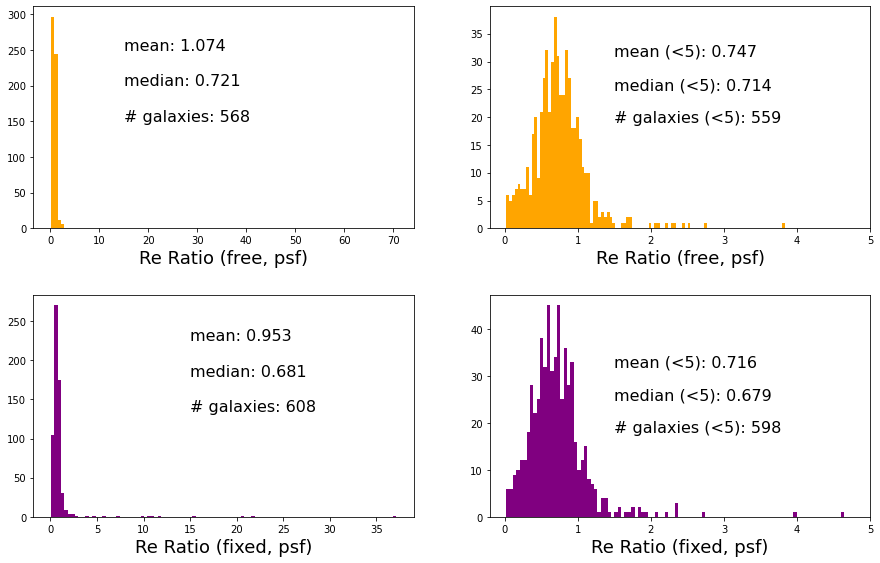

In [31]:
#prelimiary histogram plots (free psf, fixed psf; two different magnifications)...

fig = plt.figure(figsize=(15,20))
plt.subplots_adjust(hspace=.3,wspace=.2)
for i in range(1,5):
    ax=fig.add_subplot(4,2,i)
    
    if i == 1:
        plt.hist(re_ratio_2,bins=100,color='orange')
        plt.xlabel('Re Ratio (free, psf)',fontsize=18)
        plt.text(15,250,'mean: '+'%.3f'%(np.mean(re_ratio_2)),fontsize=16)
        plt.text(15,200,'median: '+'%.3f'%(np.median(re_ratio_2)),fontsize=16)
        plt.text(15,150,'# galaxies: '+str(len(re_ratio_2)),fontsize=16)        
    if i == 2:
        plt.hist(re_ratio_2[(re_ratio_2<5)],bins=100,color='orange')
        plt.xlim(-0.2,5)
        plt.xlabel('Re Ratio (free, psf)',fontsize=18)
        plt.text(1.5,31,'mean (<5): '+'%.3f'%(np.mean(re_ratio_2[(re_ratio_2<5)])),fontsize=16)
        plt.text(1.5,25,'median (<5): '+'%.3f'%(np.median(re_ratio_2[(re_ratio_2<5)])),fontsize=16)
        plt.text(1.5,19,'# galaxies (<5): '+str(len(re_ratio_2[(re_ratio_2<5)])),fontsize=16)

    if i == 3:
        plt.hist(re_ratio_4,bins=100,color='purple')
        plt.xlabel('Re Ratio (fixed, psf)',fontsize=18)
        plt.text(15,225,'mean: '+'%.3f'%(np.mean(re_ratio_4)),fontsize=16)
        plt.text(15,180,'median: '+'%.3f'%(np.median(re_ratio_4)),fontsize=16)
        plt.text(15,135,'# galaxies: '+str(len(re_ratio_4)),fontsize=16)
    if i == 4:
        plt.hist(re_ratio_4[(re_ratio_4<5)],bins=100,color='purple')
        plt.xlim(-0.2,5)
        plt.xlabel('Re Ratio (fixed, psf)',fontsize=18)
        plt.text(1.5,32,'mean (<5): '+'%.3f'%(np.mean(re_ratio_4[(re_ratio_4<5)])),fontsize=16)
        plt.text(1.5,25,'median (<5): '+'%.3f'%(np.median(re_ratio_4[(re_ratio_4<5)])),fontsize=16)
        plt.text(1.5,18,'# galaxies (<5): '+str(len(re_ratio_4[(re_ratio_4<5)])),fontsize=16)   

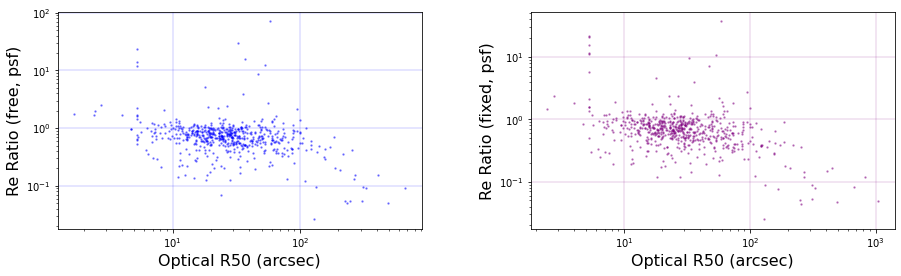

In [32]:
#scatterplots of ratio vs. optical Re

fig = plt.figure(figsize=(15,10))
plt.subplots_adjust(hspace=.5,wspace=.3)
for i in range(1,3):
    ax=fig.add_subplot(2,2,i)
    
    if i == 1:
        plt.scatter(r50_2,re_ratio_2,color='blue',alpha=0.4,s=2)
        plt.ylabel('Re Ratio (free, psf)',fontsize=16)
        plt.xlabel('Optical R50 (arcsec)',fontsize=16)   
        plt.xscale('log')
        plt.yscale('log')
        plt.grid(color='b',linewidth=0.2)
    
    if i == 2:
        plt.scatter(r50_4,re_ratio_4,color='purple',alpha=0.4,s=2)
        plt.ylabel('Re Ratio (fixed, psf)',fontsize=16)
        plt.xlabel('Optical R50 (arcsec)',fontsize=16)
        plt.xscale('log')
        plt.yscale('log')
        plt.grid(color='purple',linewidth=0.2)

In [33]:
#Spearman rank correlation test

print('Free Correlation (rho value, all) '+'%0.4f'%spearmanr(r50_2,re_ratio_2)[0])
print('Free Correlation (p value, all) '+'%0.12f'%spearmanr(r50_2,re_ratio_2)[1])
print(' ')
print('Free Correlation (rho value, noWISE_AGN) '+'%0.4f'%spearmanr(r50_2[wise_agn_flag2],re_ratio_2[wise_agn_flag2])[0])
print('Free Correlation (p value, noWISE_AGN) '+'%0.12f'%spearmanr(r50_2[wise_agn_flag2],re_ratio_2[wise_agn_flag2])[1])
print(' ')
print('Free Correlation (rho value, noBPT_AGN) '+'%0.4f'%spearmanr(r50_2[kauffman_agn_flag2],re_ratio_2[kauffman_agn_flag2])[0])
print('Free Correlation (p value, noBPT_AGN) '+'%0.4f'%spearmanr(r50_2[kauffman_agn_flag2],re_ratio_2[kauffman_agn_flag2])[1])
print(' ')
print(' ')
print('Fixed Correlation (rho value, all) '+'%0.4f'%spearmanr(r50_4,re_ratio_4)[0])
print('Fixed Correlation (p value, all) '+'%0.16f'%spearmanr(r50_4,re_ratio_4)[1])
print(' ')
print('Fixed Correlation (rho value, noWISE_AGN) '+'%0.4f'%spearmanr(r50_4[wise_agn_flag4],re_ratio_4[wise_agn_flag4])[0])
print('Fixed Correlation (p value, noWISE_AGN) '+'%0.16f'%spearmanr(r50_4[wise_agn_flag4],re_ratio_4[wise_agn_flag4])[1])
print(' ')
print('Fixed Correlation (rho value, noBPT_AGN) '+'%0.4f'%spearmanr(r50_4[kauffman_agn_flag4],re_ratio_4[kauffman_agn_flag4])[0])
print('Fixed Correlation (p value, noBPT_AGN) '+'%0.7f'%spearmanr(r50_4[kauffman_agn_flag4],re_ratio_4[kauffman_agn_flag4])[1])

#"If the p-value of the correlation is less than 0.05, the correlation is statistically significant."

Free Correlation (rho value, all) -0.2810
Free Correlation (p value, all) 0.000000000009
 
Free Correlation (rho value, noWISE_AGN) -0.2823
Free Correlation (p value, noWISE_AGN) 0.000000000008
 
Free Correlation (rho value, noBPT_AGN) -0.3398
Free Correlation (p value, noBPT_AGN) 0.0010
 
 
Fixed Correlation (rho value, all) -0.3221
Fixed Correlation (p value, all) 0.0000000000000004
 
Fixed Correlation (rho value, noWISE_AGN) -0.3239
Fixed Correlation (p value, noWISE_AGN) 0.0000000000000003
 
Fixed Correlation (rho value, noBPT_AGN) -0.4743
Fixed Correlation (p value, noBPT_AGN) 0.0000007


# SFR v. Mstar plots

In [34]:
#SFR vs. Mstar plots for 704 galaxy subset

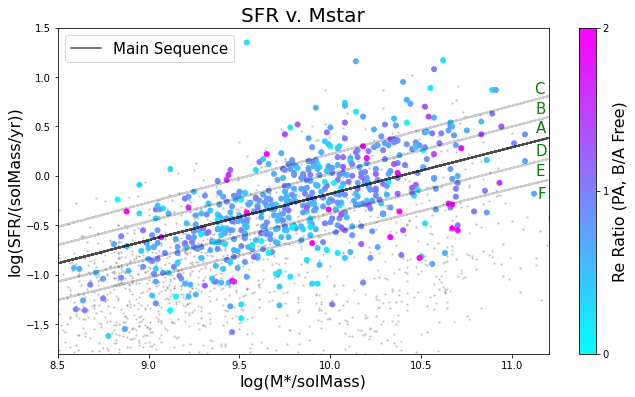

In [35]:
#size ratio v. offset from main sequence (FREE)

#defining subset...mgs from Leroy+14 paper
mgs = Table.read(homedir+'/Desktop/v1-20210308/vf_north_v1_z0mgs.fits')
#cut sample to 933
mgstab = mgs[flag_hyp]
#cut sample to 704 using sgacut flag
mgstab = mgstab[flag_sga2]

Mstar = mgstab['logmass'] #x-axis
SFR = mgstab['logsfr'] #y-axis; frequently found with W4 data
D25 = 10**(hyp['logd25'])

#full catalog...
Mstar_full = mgs['logmass']
SFR_full = mgs['logsfr']

plt.figure(figsize=(11,6))
plt.scatter(Mstar_full,SFR_full,color='gray',s=2,alpha=0.3)
plt.scatter(Mstar[t2_error],SFR[t2_error],c=re_ratio_2,cmap='cool',linewidths=1,vmin=0,vmax=2,s=25,alpha=1)

cb = plt.colorbar(ticks=range(0,5,1))

cb.set_label('Re Ratio (PA, B/A Free)',fontsize=16)
plt.xlabel('log(M*/solMass)',fontsize=16)
plt.ylabel('log(SFR/(solMass/yr))',fontsize=16)
plt.title('SFR v. Mstar', fontsize=20)

#trim the "gray" perimeter to magnify on the central, colored points
plt.xlim(8.5,11.2)
plt.ylim(-1.8,1.5)

#best-fit line test...
#slope: 0.47 +/- 0.01
#y-intercept: -4.88 +/- 0.10
y = Mstar_full*0.47 - 4.88

#edgecolors='k'

onestd_upper = Mstar_full*(0.47+0.01) - (4.88-0.1)
onestd_lower = Mstar_full*(0.47-0.01) - (4.88+0.1)
twostd_upper = Mstar_full*(0.47+0.02) - (4.88-0.2)
twostd_lower = Mstar_full*(0.47-0.02) - (4.88+0.2)

plt.plot(Mstar_full,y,label=('Main Sequence'),color='black',alpha=0.7)
plt.plot(Mstar_full,onestd_upper,'black',linestyle='--',alpha=0.2)
plt.plot(Mstar_full,onestd_lower,'black',linestyle='--',alpha=0.2)
plt.plot(Mstar_full,twostd_upper,'black',linestyle='--',alpha=0.2)
plt.plot(Mstar_full,twostd_lower,'black',linestyle='--',alpha=0.2)

#defining regions
plt.text(11.13,0.44,'A',fontsize=15,color='g',label=r'+3$\sigma$')
plt.text(11.13,0.63,'B',fontsize=15,color='g',label=r'+2$\sigma$')
plt.text(11.122,0.83,'C',fontsize=15,color='g',label=r'+1$\sigma$')
plt.text(11.13,0.21,'D',fontsize=15,color='g',label=r'-1$\sigma$')
plt.text(11.13,0.0,'E',fontsize=15,color='g',label=r'-2$\sigma$')
plt.text(11.14,-0.23,'F',fontsize=15,color='g',label=r'-3$\sigma$')

plt.legend(loc='upper left',fontsize=15)

In [36]:
Mstar_free = Mstar[t2_error]
SFR_free = SFR[t2_error]

main_sequence_free = Mstar_free*0.47 - 4.88
onestd_upper_free = Mstar_free*(0.47+0.01) - (4.88-0.1)
onestd_lower_free = Mstar_free*(0.47-0.01) - (4.88+0.1)
twostd_upper_free = Mstar_free*(0.47+0.02) - (4.88-0.2)
twostd_lower_free = Mstar_free*(0.47-0.02) - (4.88+0.2)

A_flag_free = (SFR_free>main_sequence_free) & (SFR_free<onestd_upper_free)
B_flag_free = (SFR_free>onestd_upper_free) & (SFR_free<twostd_upper_free)
C_flag_free = (SFR_free>twostd_upper_free)
D_flag_free = (SFR_free>onestd_lower_free) & (SFR_free<main_sequence_free)
E_flag_free = (SFR_free>twostd_lower_free) & (SFR_free<onestd_lower_free)
F_flag_free = (SFR_free<twostd_lower_free)

In [37]:
#Re ratio bins:
#0 to 0.539 (first)
#0.539 to 0.721 (second)
#0.721 to 0.92 (third)
#0.92+ (fourth)

re_ratio_2A = re_ratio_2[A_flag_free]
A = [0,0,0,0]

re_ratio_2B = re_ratio_2[B_flag_free]
B = [0,0,0,0]

re_ratio_2C = re_ratio_2[C_flag_free]
C = [0,0,0,0]

re_ratio_2D = re_ratio_2[D_flag_free]
D = [0,0,0,0]

re_ratio_2E = re_ratio_2[E_flag_free]
E = [0,0,0,0]

re_ratio_2F = re_ratio_2[F_flag_free]
F = [0,0,0,0]

ratios = [re_ratio_2A,re_ratio_2B,re_ratio_2C,re_ratio_2D,re_ratio_2E,re_ratio_2F]
regions = [A,B,C,D,E,F]

for n in range(0,len(ratios)):
    for i in ratios[n]:
        if (float(i)>0) & (float(i)<=0.539):
            regions[n][0] += 1
        if (float(i)>0.539) & (float(i)<=0.721):
            regions[n][1] +=1
        if (float(i)>0.721) & (float(i)<=0.92):
            regions[n][2] += 1
        if (float(i)>0.92):
            regions[n][3] += 1      

In [38]:
#the printed text is not helpful, but I keep this (and above) cell here as a reminder of how 
#not to present offsets. :-)

#Re ratio bins:
#0 to 0.539 (first)
#0.539 to 0.721 (second)
#0.721 to 0.92 (third)
#0.92+ (fourth)

print('Offset:  first Q,   second Q,   third Q,   fourth Q')
print('+1sig:',A/np.sum(A))
print('-1sig:',D/np.sum(D))
print('+2sig:',B/np.sum(B))
print('-2sig:',E/np.sum(E))
print('+3sig:',C/np.sum(C))
print('-3sig:',F/np.sum(F))

Offset:  first Q,   second Q,   third Q,   fourth Q
+1sig: [0.19811321 0.27358491 0.32075472 0.20754717]
-1sig: [0.2195122  0.31707317 0.25203252 0.21138211]
+2sig: [0.19230769 0.20192308 0.29807692 0.30769231]
-2sig: [0.32967033 0.16483516 0.26373626 0.24175824]
+3sig: [0.32142857 0.28571429 0.125      0.26785714]
-3sig: [0.27906977 0.25581395 0.13953488 0.3255814 ]


In [39]:
#alternatively, I plot distance from MS vs. size ratio, or vice versa...may be more
#revealing...
#Distance = (| a*x1 + b*y1 + c |) / (sqrt( a*a + b*b))

d2 = (0.47*Mstar[t2_error] - SFR[t2_error] - 4.88) / (np.sqrt(0.47**2 + 1**2))
d4 = (0.47*Mstar[t4_error] - SFR[t4_error] - 4.88) / (np.sqrt(0.47**2 + 1**2))

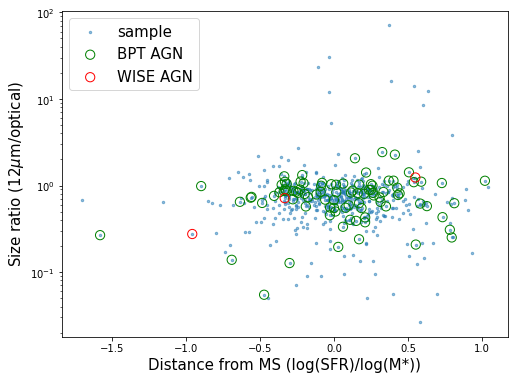

In [147]:
plt.figure(figsize=(8,6))
plt.scatter(d2,re_ratio_2,s=6,alpha=0.5,label='sample')
plt.yscale('log')
plt.ylabel(r'Size ratio (12$\mu$m/optical)',fontsize=15)
plt.xlabel('Distance from MS (log(SFR)/log(M*))',fontsize=15)

plt.scatter(d2[kauffman_agn_flag2], re_ratio_2[kauffman_agn_flag2], s=85, facecolors='none', 
            edgecolors='g',label='BPT AGN')
plt.scatter(d2[~wise_agn_flag2], re_ratio_2[~wise_agn_flag2], s=85, facecolors='none', 
            edgecolors='r',label='WISE AGN')

plt.legend(loc='upper left',fontsize=15)

In [41]:
#Spearman rank correlation test
#~kauffman_agn_flag excludes BPT AGN
#wise_agn_flag exclude WISE AGN

print('Free Correlation (rho value, all) '+'%0.4f'%spearmanr(d2,re_ratio_2)[0])
print('Free Correlation (p value, all) '+'%0.4f'%spearmanr(d2,re_ratio_2)[1])
print(' ')
print('Free Correlation (rho value, noWISEAGN) '+'%0.4f'%spearmanr(d2[wise_agn_flag2],re_ratio_2[wise_agn_flag2])[0])
print('Free Correlation (p value, noWISEAGN) '+'%0.4f'%spearmanr(d2[wise_agn_flag2],re_ratio_2[wise_agn_flag2])[1])
print(' ')
print('Free Correlation (rho value, noBPTAGN) '+'%0.4f'%spearmanr(d2[~kauffman_agn_flag2],re_ratio_2[~kauffman_agn_flag2])[0])
print('Free Correlation (p value, noBPTAGN) '+'%0.4f'%spearmanr(d2[~kauffman_agn_flag2],re_ratio_2[~kauffman_agn_flag2])[1])

#"However, since the p-value of the correlation is not less than 0.05, 
#the correlation is not statistically significant."

#np.linspace degree=1 fit reveals another narrative, which may indicate its not being appropriate here. :-)

Free Correlation (rho value, all) -0.0546
Free Correlation (p value, all) 0.1941
 
Free Correlation (rho value, noWISEAGN) -0.0635
Free Correlation (p value, noWISEAGN) 0.1319
 
Free Correlation (rho value, noBPTAGN) -0.0678
Free Correlation (p value, noBPTAGN) 0.1390


In [42]:
#neither case eliminates the most significant outliers (contrary to slight expectation). 
#these outliers, however, may simply be attributable to poor GALFIT modeling

#worth continuing to mark AGN galaxies?

#HIGH ratio outliers:
#VFID4272 
#   has re_ratio = 70.64; Re_free (PSF) = 1507.8247 +/- 400.2283 px
#   prominent bars, quite a bit of over/undersubtraction in residuals
#VFID0432
#   re_ratio = 30.42; Re_free (PSF) = 361.16 +/- 177.63 px, but noPSF is more reasonable at 67.5 +/- 6.71
#   Similar structure as galaxy above, heaps of over/undersubtraction

#LOW ratio outliers:
#VFID6420
#   re_ratio = 0.027; Re_free (PSF) = 1.254 +/- 0.0383
#   Highly truncated disk; may or may not reflect the dust distribution of the galaxy
#VFID6169
#   re_ratio = 0.056; Re_free (PSF) = 5.023 +/- 0.029
#   Similar as above, though not seemingly as heavily truncated

In [43]:
#The "check" commands

#np.where(re_ratio_2<0.06)
#re_ratio_2[527]
#vfid_2[527]

# Ratios according to environment bins

In [44]:
#histogram attempt not terribly revealing, especially since I merged bins that should not have been merged.
#instead, will use violin plot to illustrate size ratios as a function of environmental density (the bins
#as defined above)

In [55]:
#first import and trim the Virgo environment catalog

env = Table.read(homedir+'/Desktop/v1-20210308/vf_north_v1_main_envsummary_Kourkchi.fits')

#cuts sample to 933
envcut = env[flag_hyp]
#cuts sample to 704 (using sgacut flag)
envcut = envcut[flag_sga2]

#envcut column names: flag_clus (0,1), flag_fil (0,1), flag_isol (0,1), flag_gro (0, 1, 2), flag_clus_k (0,1)

In [56]:
#isolate columns; convert 0,1 to False,True

cluster = envcut['flag_clus']
cluster = np.asarray(list(map(bool,cluster)))

filament = envcut['flag_fil']
filament = np.asarray(list(map(bool,filament)))

field = envcut['flag_isol']
field = np.asarray(list(map(bool,field)))

group = envcut['flag_gro']
#poor group
pg_flag = []
#rich group
rg_flag = []

#define rich, poor groups 

for n in range(0,704):
    if int(group[n]) == 1:
        rg_flag.append(False)
        pg_flag.append(True)
    if int(group[n]) == 2:
        rg_flag.append(True)
        pg_flag.append(False)
    if int(group[n]) == 0:
        rg_flag.append(False)
        pg_flag.append(False)
        
rg_flag = np.asarray(rg_flag)
pg_flag = np.asarray(pg_flag)

In [68]:
#CL
cluster = cluster

#Filament and rich group
fil_rg = (rg_flag) & (filament)

#rich group (all, meaning isolated rich groups or those in filaments)
rg_all = (rg_flag)

#rich group only (include if the row only has a "2")
rg = (rg_flag) & (~fil_rg)

#filament (all galaxies with filament marker)
filament = filament

#filament galaxies that do not belong to a rich group
fil_only = (filament) & (~rg_flag)

#poor group
pg_flag = pg_flag

#pure field
field = field

In [69]:
#trimming bool parameters according to galaxies with GALFIT numerical errors, for both free and fixed cases

cluster_free = cluster[t2_error]
fil_rg_free = fil_rg[t2_error]
rg_all_free = rg_all[t2_error]
rg_free = rg[t2_error]
filament_free = filament[t2_error]
filament_iso_free = fil_only[t2_error]
pg_free = pg_flag[t2_error]
field_free = field[t2_error]


cluster_fixed = cluster[t4_error]
fil_rg_fixed = fil_rg[t4_error]
rg_all_fixed = rg_all[t4_error]
rg_fixed = rg[t4_error]
filament_fixed = filament[t4_error]
filament_iso_fixed = fil_only[t4_error]
pg_fixed = pg_flag[t4_error]
field_fixed = field[t4_error]

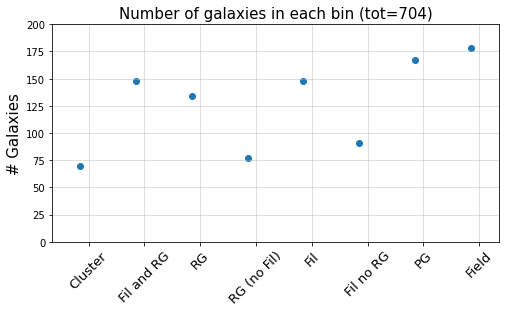

In [78]:
#first plot num of galaxies in each bin
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)
ind=np.arange(0,8,1)
width=0.15

x = np.array([1,2,3,4,5,6,7,8])-1
data1 = np.array([len(cluster_re_free),len(fil_rg_re_free),len(rg_all_re_free),len(rg_re_free),
                 len(filament_re_free),len(fil_iso_re_free),len(pg_re_free),len(field_re_free)])

data2 = np.array([len(cluster_re_fixed),len(fil_rg_re_fixed),len(rg_all_re_fixed),len(rg_re_fixed),
                 len(filament_re_fixed),len(fil_iso_re_fixed),len(pg_re_fixed),len(field_re_fixed)])

plt.scatter(x,data1)
#plt.scatter(x,data2)
plt.title('Number of galaxies in each bin (tot=704)',fontsize=15)
plt.ylabel('# Galaxies',fontsize=15)
plt.ylim(0,200)

ax.set_xlim(-width,len(ind)-1.5*width)
xTickMarks= ['Cluster','Fil and RG','RG','RG (no Fil)','Fil','Fil no RG','PG','Field']
ax.set_xticks(ind+width)
xtickNames=ax.set_xticklabels(xTickMarks)
plt.setp(xtickNames,rotation=45,fontsize=13)
plt.xlim(-0.5,7.5)
plt.grid(alpha=0.5)

## Violin Plot...

In [70]:
#isolate re_ratios for each category

cluster_re_free = re_ratio_2[cluster_free]
fil_rg_re_free = re_ratio_2[filament_free]
rg_all_re_free = re_ratio_2[rg_all_free]
rg_re_free = re_ratio_2[rg_free]
filament_re_free = re_ratio_2[filament_free]
fil_iso_re_free = re_ratio_2[filament_iso_free]
pg_re_free = re_ratio_2[pg_free]
field_re_free = re_ratio_2[field_free]

cluster_re_fixed = re_ratio_4[cluster_fixed]
fil_rg_re_fixed = re_ratio_4[filament_fixed]
rg_all_re_fixed = re_ratio_4[rg_all_fixed]
rg_re_fixed = re_ratio_4[rg_fixed]
filament_re_fixed = re_ratio_4[filament_fixed]
fil_iso_re_fixed = re_ratio_4[filament_iso_fixed]
pg_re_fixed = re_ratio_4[pg_fixed]
field_re_fixed = re_ratio_4[field_fixed]

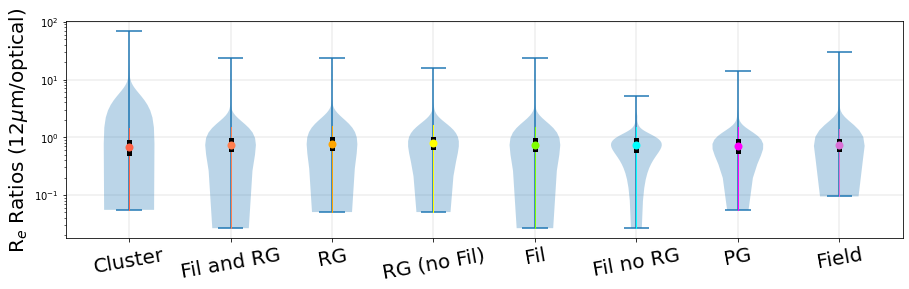

In [205]:
env_names = ['Cluster','Fil and RG','RG','RG (no Fil)','Fil','Fil no RG','PG','Field']
#x axis --> env names; y axis --> Re ratios

#set up the canvas
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 4))

#data corresponding, I assume, to each env bin. I will populate the list as such
data =[cluster_re_free, fil_rg_re_free, rg_all_re_free, rg_re_free, filament_re_free, fil_iso_re_free,
       pg_re_free, field_re_free]

# mod = mode?
mod = []

# median
med = []

# inter-quartile ranges; IQR = stats.iqr(data, interpolation = 'midpoint')
iqr = []

# upper and lower adjacent values
# UAV = Q3 + 1.5*IQR 
# LAV = Q1 - 1.5*IQR
avs = []

#taken from https://matplotlib.org/2.0.2/examples/statistics/customized_violin_demo.html
def adjacent_values(vals):  
    q1 = np.percentile(vals,25)
    q3 = np.percentile(vals,75)
    upper_adjacent_value = q3 + ((q3 - q1) * 1.5)
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])
    lower_adjacent_value = q1 - ((q3 - q1) * 1.5)
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value   

for arr in data:
    sarr = sorted(arr)
    med.append(percentile(sarr, 50))   #used 50 instead of 0.5
    mod.append(stats.mode(np.asarray(sarr)[np.isfinite(sarr)].astype(int)))
    iqr.append([percentile(sarr, 32), percentile(sarr, 68)])   #used 32, 68 instead of 0.32, 0.68
    avs.append(adjacent_values(sarr))
    
plt.rcParams['axes.axisbelow'] = True
plt.rc('grid', c='0.5', ls='-', lw=0.2)
plt.grid(True)

ticks=np.arange(0,8,1)
parts = ax.violinplot(data, positions=ticks,widths =0.5, showmeans=False, showmedians=False,
                  showextrema=True)

med_col = ['tomato','coral','orange','yellow','chartreuse','cyan','fuchsia','orchid']
avs_col = ['tomato','coral','orange','yellow','chartreuse','cyan','fuchsia','orchid']

for i in range(len(med)):
    ax.plot([i, i], avs[i], '-', lw=1, zorder = 7,color=avs_col[i])
    ax.plot([i, i], iqr[i], '-', lw=5, zorder = 7,color='black')
    ax.plot(i, med[i], 'o', mec='none', ms=8, zorder = 7,color=med_col[i],label=str(env_names[i])+' Median')

med_ld = med
err_ld = iqr

plt.xticks(ticks,env_names, rotation=10, fontsize=20)

plt.ylabel(r"R$_e$ Ratios (12$\mu$m/optical)",fontsize=20)
#plt.legend()
plt.yscale('log')

1. for galaxies 10%, 20%, 30%, 40% suppressed --> determine fraction of the sample in every environment that has sizes below these suppression "thresholds" relative to the median. Plot with binomial errors. 
2. inspect galaxies with high size ratios...are models reliable? Large errors? Large discrepancies between no psf and psf, if galaxies are massive?
3. create size ratio vs. MS distance for each environmental bin, to assess whether there are trends hidden in the full sample plot. 

In [ ]:
fig = plt.figure(figsize=(15,20))
plt.subplots_adjust(hspace=.3,wspace=.2)
for i in range(1,5):
    ax=fig.add_subplot(4,2,i)
    
    if i == 1:
        plt.hist(re_ratio_2,bins=100,color='orange')
        plt.xlabel('Re Ratio (free, psf)',fontsize=18)
        plt.text(15,250,'mean: '+'%.3f'%(np.mean(re_ratio_2)),fontsize=16)
        plt.text(15,200,'median: '+'%.3f'%(np.median(re_ratio_2)),fontsize=16)
        plt.text(15,150,'# galaxies: '+str(len(re_ratio_2)),fontsize=16)        
    if i == 2:
        plt.hist(re_ratio_2[(re_ratio_2<5)],bins=100,color='orange')
        plt.xlim(-0.2,5)
        plt.xlabel('Re Ratio (free, psf)',fontsize=18)
        plt.text(1.5,31,'mean (<5): '+'%.3f'%(np.mean(re_ratio_2[(re_ratio_2<5)])),fontsize=16)
        plt.text(1.5,25,'median (<5): '+'%.3f'%(np.median(re_ratio_2[(re_ratio_2<5)])),fontsize=16)
        plt.text(1.5,19,'# galaxies (<5): '+str(len(re_ratio_2[(re_ratio_2<5)])),fontsize=16)

    if i == 3:
        plt.hist(re_ratio_4,bins=100,color='purple')
        plt.xlabel('Re Ratio (fixed, psf)',fontsize=18)
        plt.text(15,225,'mean: '+'%.3f'%(np.mean(re_ratio_4)),fontsize=16)
        plt.text(15,180,'median: '+'%.3f'%(np.median(re_ratio_4)),fontsize=16)
        plt.text(15,135,'# galaxies: '+str(len(re_ratio_4)),fontsize=16)
    if i == 4:
        plt.hist(re_ratio_4[(re_ratio_4<5)],bins=100,color='purple')
        plt.xlim(-0.2,5)
        plt.xlabel('Re Ratio (fixed, psf)',fontsize=18)
        plt.text(1.5,32,'mean (<5): '+'%.3f'%(np.mean(re_ratio_4[(re_ratio_4<5)])),fontsize=16)
        plt.text(1.5,25,'median (<5): '+'%.3f'%(np.median(re_ratio_4[(re_ratio_4<5)])),fontsize=16)
        plt.text(1.5,18,'# galaxies (<5): '+str(len(re_ratio_4[(re_ratio_4<5)])),fontsize=16)   

# SCRAP -- comparing d25 (Hyperleda) and r50 (Legacy Survey)

Text(0.5, 1.0, 'All 704 Galaxies')

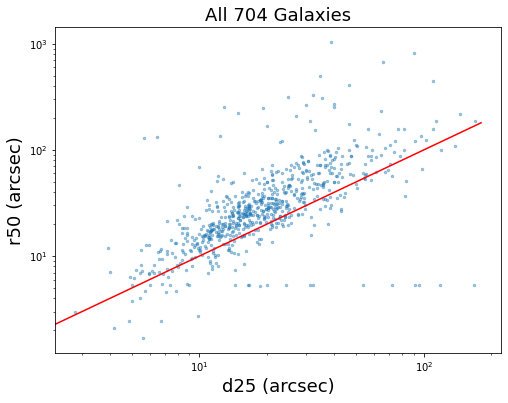

In [52]:
#having a look at d25 and r50.
plt.figure(figsize=(8,6))
d25 = 10**(hyp['logd25'])
r25=d25/2
plt.scatter(d25,r50,s=6,alpha=0.4)
plt.ylabel('r50 (arcsec)',fontsize=18)
plt.xlabel('d25 (arcsec)',fontsize=18)
plt.yscale('log')
plt.xscale('log')
plt.plot(([0,180]),([0,180]),'r')
plt.title('All 704 Galaxies',fontsize=18)

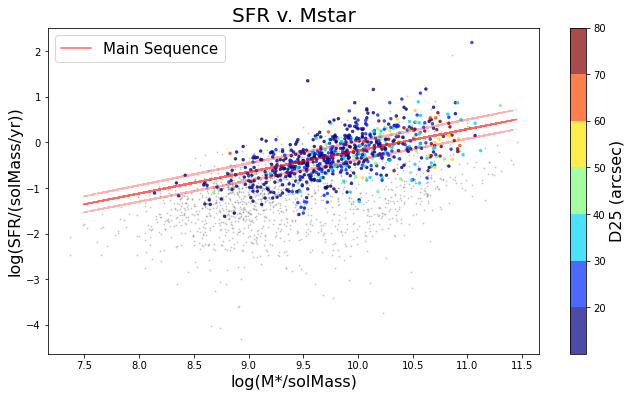

In [54]:
#function for discrete cmap, because I can
def discrete_cmap(N,base_cmap=None):
    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0,1,N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name,color_list,N)

#defining subset...mgs from Leroy paper
mgs = Table.read(homedir+'/Desktop/v1-20210308/vf_north_v1_z0mgs.fits')
#cuts sample to 933
mgstab = mgs[flag_hyp]
#cuts sample to 704 (using sgacut flag)
mgstab = mgstab[flag_sga2]

Mstar = mgstab['logmass']  #x axis
SFR = mgstab['logsfr']   #y axis; frequently found with WISE C4 data
D25 = 10**(hyp['logd25'])

#full catalog...
Mstar_full = mgs['logmass']
SFR_full = mgs['logsfr']

plt.figure(figsize=(11,6))
plt.scatter(Mstar_full,SFR_full,color='gray',s=1,alpha=0.3)
plt.scatter(Mstar,SFR,c=D25,cmap=discrete_cmap(7,'jet'),s=6,alpha=0.7)

#ensures 10 tick marks corresponding with 4 discrete colors
cb = plt.colorbar(ticks=range(20,100,10))

#defines tick bar upper and lower bounds
plt.clim(10,80)
cb.set_label('D25 (arcsec)',fontsize=16)
plt.xlabel('log(M*/solMass)',fontsize=16)
plt.ylabel('log(SFR/(solMass/yr))',fontsize=16)
plt.title('SFR v. Mstar', fontsize=20)

#best-fit line test...
#slope: 0.47 +/- 0.01
#y-intercept: -4.88 +/- 0.10
y = Mstar_full*0.47 - 4.88
mean_upper = Mstar_full*(0.47+0.01) - (4.88-0.1)
mean_lower = Mstar_full*(0.47-0.01) - (4.88+0.1)
plt.plot(Mstar_full,y,label=('Main Sequence'),color='red',alpha=0.6)
plt.plot(Mstar_full,mean_upper,'r',linestyle='dashed',alpha=0.3)
plt.plot(Mstar_full,mean_lower,'r',linestyle='dashed',alpha=0.3)
#plt.fill_between(Mstar_full,mean_lower,mean_upper,alpha=0.005,color='orange')
plt.legend(fontsize=15)

In [83]:
for i in enumerate(env_names):
    print(i)

(0, 'Cluster')
(1, 'Fil and RG')
(2, 'RG')
(3, 'RG (no Fil)')
(4, 'Fil')
(5, 'Fil no RG')
(6, 'PG')
(7, 'Field')
